<a href="https://colab.research.google.com/github/HsYg/HsPyPJ/blob/master/DT_modeling_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f

<PCA IMplementation>
https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60



# **0. Environment Preparation**

In [0]:
#!pip install pandas-profiling
#!pip install matplotlib==3.1.0
#!pip install numpy --upgrade
#!pip install pandas --upgrade
#!pip install seaborn --upgrade
#!pip install sklearn --upgrade
!pip install japanize-matplotlib
!apt-get -y install fonts-ipafont-gothic

import matplotlib
import japanize_matplotlib #Japanese font#
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import codecs

from scipy.stats.mstats import winsorize
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,f_regression,mutual_info_regression

%matplotlib inline


matplotlib.rcParams['font.family'] = ['IPAexGothic']
sns.set(font='IPAGothic')


import pandas_profiling
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%matplotlib inline
pd.options.display.max_columns = None	

# Helper functions

from collections.abc import Iterable

def drop_outliers(df, columns_to_check, thresholds):
    """Drop outliers from a dataframe.

    Args:
      columns_to_check: A list of column names to check for outliers.
      thresholds: A list of threshold values to identify outliers. The length
          of this list must be the same as columns_to_check.
    Returns:
      A dataframe with outliers removed.
    """
    if (isinstance(columns_to_check, str)
        or not isinstance(columns_to_check, Iterable)):
        columns_to_check = [columns_to_check]
    if not isinstance(thresholds, Iterable):
        thresholds = [thresholds]
    assert len(columns_to_check) == len(thresholds)

    returned_df = df.copy()
    for col_name, thres in zip(columns_to_check, thresholds):
        returned_df.drop(returned_df[returned_df[col_name] >= thres].index,
                         inplace=True)
    return returned_df

def drop_outliers_IQR(df, columns_to_check):
    returned_df = df.copy()
    thresholds_u=[]
    thresholds_d=[]    
    for c in columns_to_check:
      Q1 = df[c].quantile(0.25) 
      Q3 = df[c].quantile(0.75)
      thresholds_u.append(Q3+1.5*(Q3 - Q1))
      thresholds_d.append(Q1-1.5*(Q3 - Q1))
      
    for col_name, thres in zip(columns_to_check, thresholds_u):
      returned_df.drop(returned_df[returned_df[col_name] >= thres].index,
                         inplace=True)
    for col_name, thres in zip(columns_to_check, thresholds_d):
      returned_df.drop(returned_df[returned_df[col_name] <= thres].index,
                         inplace=True)
    return returned_df

def drop_outliers_IQR_with_thresholds(df, columns_to_check):
    returned_df = df.copy()
    thresholds_u=[]
    thresholds_d=[]    
    for c in columns_to_check:
      Q1 = df[c].quantile(0.25) 
      Q3 = df[c].quantile(0.75)
      thresholds_u.append(Q3+1.5*(Q3 - Q1))
      thresholds_d.append(Q1-1.5*(Q3 - Q1))
    
    outlier_count = pd.DataFrame(0,columns=['c'],index=columns_to_check)
    returned_df['outlier_count']=0 
      
    for col_name, thres in zip(columns_to_check, thresholds_u):
      for index,row in returned_df.iterrows():
        if returned_df.loc[index,col_name] > thres:
          returned_df.loc[index,'outlier_count']= returned_df.loc[index,'outlier_count']+1
                     
    for col_name, thres in zip(columns_to_check, thresholds_d):
      for index,row in returned_df.iterrows():
        if returned_df.loc[index,col_name] < thres:
          returned_df.loc[index,'outlier_count']= returned_df.loc[index,'outlier_count']+1
                     
#    returned_df.drop( returned_df[returned_df['outlier_count'] >= thresholds].index,
#                        inplace=True)
#    returned_df =  returned_df.drop('outlier_count' , axis='columns')
    return returned_df  
def chk_tas_correlation(df,cols):
  numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  num_df = df.select_dtypes(include=numerics)
  num_df=num_df.drop(['Id'],axis=1)
  corr = num_df.dropna().corr().abs().stack()
  rowData =num_df.dropna().corr().loc[cols, : ]
  # print out correlation result
  for index, row in rowData.iterrows():
    abs_row = row.abs().sort_values(ascending=False)
    w=row[abs_row[abs_row>0.25].index]
# print data category
    i = 'TA_size_s'
    for index, val in w.iteritems():
      if val >= 1: i = index
      print(i,',',index,',',val)

        
def plot_relationships_numerical(
    df,
    target,
    features,
    plot_width=8,
    plot_height=7,
):
    """Plot relationships with multiple numerical columns.
    
    Args:
        df: The dataframe from which we get the data to plot.
        target: Name of the target column.
        features: A list of column names. A plot is drawn for each column
            in the list, showing its relationship with the target column.
        plot_width: Width of each subplot.
        plot_height: Height of each subplot.
    Returns:
        None
    """
    n_features = len(features)
    n_cols = min(2, n_features)
    n_rows = (n_features + n_cols - 1) // n_cols
    figsize = (plot_width*n_cols, plot_height*n_rows)
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols,
                           figsize=figsize)
    if n_rows == 1:
        ax = [ax]
    if n_cols == 1:
        ax = [[x] for x in ax]
    
    i = 0
    for row in range(n_rows):
        for col in range(n_cols):
            if i >= n_features:
                break
            sns.regplot(x=df[features[i]],
                            y=df[target],
                            ax=ax[row][col])
            i += 1
    plt.show()
    

def plot_relationships_categorical(
    df,
    target,
    features,
    plot_width=12,
    plot_height=5,
):
    """Plot relationships with multiple categorical columns.
    
    Args:
        df: The dataframe from which we get the data to plot.
        target: Name of the target column.
        features: A list of column names. A plot is drawn for each column
            in the list, showing its relationship with the target column.
        plot_width: Width of each subplot.
        plot_height: Height of each subplot.
    Returns:
        None
    """
    n_features = len(features)
    
    # Boxplot tends to take up more horizontal space than scatter plot
    # so we should plot only 1 graph per row.
    n_cols = 1
    n_rows = n_features
    figsize = (plot_width*n_cols, plot_height*n_rows)
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols,
                           figsize=figsize)
    if n_rows == 1:
        ax = [ax]
    
    for i, feature in enumerate(features):
        sns.boxplot(x=df[feature], y=df[target], ax=ax[i])
        # For plots with too many x-labels, we can rotate the labels
        # for easier reading.
        if len(df[feature].unique()) >= 25:
            for tick in ax[i].get_xticklabels():
                tick.set_rotation(90)
    
    plt.show()
    
    
def show_missing(df):
    """Show missing data in a DataFrame."""
    total = df.isnull().sum().sort_values(ascending=False)
    missing_data = pd.DataFrame({'Total': total})
    missing_data['Percent'] = missing_data['Total'] / len(df)
    # Show only columns with missing data
    return missing_data[missing_data['Total'] > 0]

def corr_heatmap(df):
    #Create Correlation df
    corr = df.corr()
    #Plot figsize
    fig, ax = plt.subplots(figsize=(10, 10))
    #Generate Color Map
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    #Generate Heat Map, allow annotations and place floats in map
    sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
    #Apply xticks
    plt.xticks(range(len(corr.columns)), corr.columns);
    #Apply yticks
    plt.yticks(range(len(corr.columns)), corr.columns)
    #show plot
    plt.show();


Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-ipafont-gothic is already the newest version (00303-18ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# 1.read store profile

In [0]:
df_path='/content/gdrive/My Drive/Model_workbooks/CompModel/data/DT_model_data.xlsx'
df=pd.read_excel(df_path, index_col='サイトコード')
df.shape

(1487, 289)

#2.Data  processing

In [0]:
show_missing(df)

,Total,Percent
Parking Flow Rating,1487,1.000000
共用敷地面積 (m2),1118,0.751849
Store Visibility Rating,1084,0.728985
Access Rating,1040,0.699395
右折レーンの設置有無サブ,786,0.528581
店舗前スピードサブ,786,0.528581
右折専用信号の設置有無サブ,784,0.527236
中央分離帯の設置有無サブ,784,0.527236
間口［サブ］（m）,702,0.472091
右折レーンの設置有無メイン,516,0.347007


##2.11 Important categorical variable encoding

In [0]:
## Create Cafe/MDS Flag
df['Cafe_flag'] = 0
cond = (df['Café 平均月商']>0)
df['Cafe_flag'] = np.where(cond, 1, 0)
df['MDS_flag'] = 0
cond = (df['MDS 平均月商']>0)
df['MDS_flag'] = np.where(cond, 1, 0)
df['PP_flag'] = 0
cond = (df['ﾌﾟﾚｲﾗﾝﾄﾞ'] != "なし")
df['PP_flag'] = np.where(cond, 1, 0)

## Convert categorical rating: RE Rating / MD

RE_Rating_dict = {10:3,'A':2,'B':1,'C':0}
MD_dict = {'Very Good':4,'Great':3,'Good':2,'Fair':1,'Not Desirable':0}
cat_convert_cols = [
                    'Real Estate Rating',
                    'Market　Desirability Grade'
]

def convert_cat_rating(df,col_name,convt_dict):
  for key in convt_dict.keys():
    mask = df[col_name] == key
    df.loc[mask,col_name]=convt_dict[key]
  return df

df= convert_cat_rating(df,'Real Estate Rating', RE_Rating_dict)
df = convert_cat_rating(df,'Market　Desirability Grade', MD_dict)



## 2.12 feature engineering: demographic

In [0]:
df['Drive Time T.A: day_night_pop_ratio']=df['Drive Time T.A:推定昼間人口(人)']/df['Drive Time T.A:住民人口(人)']
df['450_day_night_pop_ratio']=df['450_PopMcdJP']/df['450_PopResidential']
df['1000_day_night_pop_ratio']=df['1000_PopMcdJP']/df['1000_PopResidential']
df['2500m_day_night_pop_ratio']=df['2500_PopMcdJP']/df['2500_PopResidential']
df['5000m_day_night_pop_ratio']=df['5000_PopMcdJP']/df['5000_PopResidential']


df['450_under 9 pct']=df['450_Age_00_09']/df['450_PopResidential']
df['1000_under 9 pct']=df['1000_Age_00_09']/df['1000_PopResidential']
df['2500_under 9 pct']=df['2500_Age_00_09']/df['2500_PopResidential']
df['5000_under 9 pct']=df['5000_Age_00_09']/df['5000_PopResidential']

df['450_Age_10_49 pct']=df['450_Age_10_49']/df['450_PopResidential']
df['1000_Age_10_49 pct']=df['1000_Age_10_49']/df['1000_PopResidential']
df['2500_Age_10_49 pct']=df['2500_Age_10_49']/df['2500_PopResidential']
df['5000_Age_10_49 pct']=df['5000_Age_10_49']/df['5000_PopResidential']
df['Drive Time T.A_Age_10_59_pct']=1-df['Drive Time T.A_Age_00_09_pct']-df['Drive Time T.A_Age_60_64_pct']-df['Drive Time T.A_Age_65_Plus']

df['450_over_50 pct']=df['450_Age_over_50']/df['450_PopResidential']
df['1000_over_50 pct']=df['1000_Age_over_50']/df['1000_PopResidential']
df['2500_oer_50 pct']=df['2500_Age_over_50']/df['2500_PopResidential']
df['5000_over_50 pct']=df['5000_Age_over_50']/df['5000_PopResidential']
#df_processed=train_df_processed.drop(['Drive Time T.A:推定昼間人口(人)','Drive Time T.A:9歳以下人口（人）'],axis=1)

##2.13 feature engineering: McD competitor

In [0]:
mask = (df['最寄DT迄の距離(m)'] == "25km圏内に該当店舗無し")
df.loc[mask, '最寄DT迄の距離(m)']=25999

mask = (df['最寄IS迄の距離(m)'] == "25km圏内に該当店舗無し")
df.loc[mask, '最寄IS迄の距離(m)']=25999


df["2.5km- 5km圏:McD DT店舗数"]=df["5km圏:McD DT店舗数"]-df["2.5km圏:McD DT店舗数"]

##2.2 Missing value processing

In [0]:
##SG Related Features
fill_dict = {
    'SG隣接近接の有無': 'N/A',
    '敷地内or隣接SG:SG名称': 'N/A',
    '敷地内or隣接SG:年商（億円）': 0,
    '近接SG:SG名称': 'N/A',
    '近接SG:年商（億円）': 0,  
}
columns_to_fill = list(fill_dict.keys())
df[columns_to_fill] = df[columns_to_fill].fillna(fill_dict)
##敷地面積related
cols=[
   '専用敷地面積(㎡)',
   '建物延べ床面積',
   '客席面積',
]
for c in cols:
  df[c] = (df.groupby('MM名')[c].transform(lambda x: x.fillna(x.median())))
for c in cols:
  df[c] = (df.groupby('都道府県')[c].transform(lambda x: x.fillna(x.median())))

df['共用敷地面積 (m2)']=df['共用敷地面積 (m2)'].fillna(0)

##乗用車台数・比率
#fillin Minimarket's median
cols=[
   '休日:乗用車比率',
   '平日:乗用車比率',
   '休日交通・通行量:乗用車〈台〉',      
   '平日交通・通行量:乗用車〈台〉',
]

for c in cols:
  df[c] = (df.groupby('MM名')[c]
                          .transform(lambda x: x.fillna(x.median())))
  df[c] = (df.groupby('都道府県')[c]
                          .transform(lambda x: x.fillna(x.median())))
##道路状況, Rating
fill_dict = {
#    'StoreVisibility Rating': 'N/A',
#    'Access Rating': 'N/A',
    '信号交差点の有無': 'N/A',
#     '車線数［ﾒｲﾝ/ﾐｯﾄﾞﾌﾞﾛｯｸ］',
    '右折専用信号の設置有無メイン':'N/A',
    '右折専用信号の設置有無サブ':'N/A',
    '右折レーンの設置有無メイン': 'N/A',
    '右折レーンの設置有無サブ': 'N/A',
    '中央分離帯の有無［ﾒｲﾝ/ﾐｯﾄﾞﾌﾞﾛｯｸ］': 'N/A',
    '中央分離帯の設置有無サブ': 'N/A',
    '店舗前スピードメイン': 'N/A',
    '店舗前スピードサブ':'N/A',
    'カーブの状況': 'N/A',
    '反対車線へのOUT:DT利用車両': 'N/A',
 '間口［ﾒｲﾝ/ﾐｯﾄﾞﾌﾞﾛｯｸ］（m）': 'N/A',
 '間口［サブ］（m）': 'N/A', 
}
columns_to_fill = list(fill_dict.keys())
df[columns_to_fill] = df[columns_to_fill].fillna(fill_dict)

## Other numeric variables
cols=[
 '専用卓数',
# '店舗前スピードサブ',
# '店舗前スピードメイン',
# '店舗前スピードサブ',
# '反対車線へのOUT:DT利用車両',
# '間口［ﾒｲﾝ/ﾐｯﾄﾞﾌﾞﾛｯｸ］（m）',
# '間口［サブ］（m）',
 '車線数［ﾒｲﾝ/ﾐｯﾄﾞﾌﾞﾛｯｸ］',
]

for c in cols:
  df[c] = (df[c].transform(lambda x: x.fillna(x.median())))

show_missing(df)


,Total,Percent
Parking Flow Rating,1487,1.000000
Store Visibility Rating,1084,0.728985
Access Rating,1040,0.699395
店舗基準,2,0.001345
450_over_50 pct,2,0.001345
450_under 9 pct,2,0.001345
450_Age_10_49 pct,2,0.001345
Drive Time T.A_Age_50_59_pct,1,0.000672
Drive Time T.A_Age_65_Plus.1,1,0.000672
Drive Time T.A_Age_65_Plus,1,0.000672


In [0]:
df = df.replace('N/A', 'NAN')
df = df.replace('NAN', np.nan)
df = df.replace('#NAME?', np.nan)
#df = df.dropna()
df = df.fillna('0')
show_missing(df)

,Total,Percent


##2.14 data type conersion

In [0]:
## check columns with data type = object
list(df.select_dtypes(include=['object']).columns)

['店舗名',
 '英字店舗名',
 '2019年6月時点ROGO一年未満',
 'MM名',
 'MM英語名',
 'MM MarketType',
 '都道府県',
 'TVエリア',
 'ﾄﾗ/ｻﾃ',
 'Store Category',
 '店舗基準',
 'オーダーシステム',
 '最新リモデルオープン年月日',
 'Store  Visibility Rating',
 'Access Rating',
 'Parking Flow Rating',
 '営業時間:平日From',
 '営業時間:平日TO',
 '営業時間:平日合計',
 '営業時間:土曜From',
 '営業時間:土曜TO',
 '営業時間:土曜合計',
 '営業時間:休日From',
 '営業時間:休日TO',
 '営業時間:休日合計',
 'Business Hours Weekday 営業時間 平日',
 'Business Hours Suturday 営業時間 土曜',
 'Business Hours Sunday 営業時間 日曜',
 'Drive Time T.A:時分圏',
 'ｽﾀｯｷﾝｸﾞ台数（台）',
 '信号交差点の有無',
 '右折専用信号の設置有無メイン',
 '右折専用信号の設置有無サブ',
 '右折レーンの設置有無メイン',
 '右折レーンの設置有無サブ',
 '中央分離帯の有無［ﾒｲﾝ/ﾐｯﾄﾞﾌﾞﾛｯｸ］',
 '中央分離帯の設置有無サブ',
 '店舗前スピードメイン',
 '店舗前スピードサブ',
 'カーブの状況',
 '反対車線へのOUT:DT利用車両',
 '間口［ﾒｲﾝ/ﾐｯﾄﾞﾌﾞﾛｯｸ］（m）',
 '間口［サブ］（m）',
 'ﾌﾟﾚｲﾗﾝﾄﾞ',
 'SG隣接近接の有無',
 '敷地内or隣接SG:SG名称',
 '敷地内or隣接SG:年商（億円）',
 '近接SG:SG名称',
 '近接SG:年商（億円）',
 '平/土/日セールス',
 '平均AC',
 '2017\nEATIN',
 '2017\nTAKEOUT',
 '2017\nFront Counter',
 '2017\nDT',
 'PriceTier',
 'Designation',
 'Drive Time T.A_Age_00_09_pct',
 'Dr

In [0]:
##Convert objct to numeric
col_to_convert=[
 '450_Age_10_49 pct',
 'Drive Time T.A_Age_00_09_pct',
 'Drive Time T.A_Age_10_59_pct'
]
for c in col_to_convert:
  df[c] = pd.to_numeric(df[c],errors='coerce')

##2.3 Train/Test data separation

In [0]:
## use DT stores opening after 2014 as test stores
test_stores = [
14749,
27768,
24561,
11746,
27769,
21581,
40643,
23775,
14750,
23767,
1635,
26593,
28668,
12694,
23769,
27773,
46530,
8633,
11742,
27771,
7548,
15560,
1634,
38543,
1636,
28667,
28669,
23770,
38544,
11745,
8632,
28673,
26592,
28671,
38545,
23772,
38546,
22639,
36522,
28670,
27770,
35534,
37535,
23771,
35533,
25559

]

test_store_chk = df.index.isin(test_stores)
train_df_all=df[~test_store_chk]
test_df_all=df[test_store_chk]


##2.4 Numerical /categorial fields separation

In [0]:
df_numeric = df.select_dtypes(np.number)
train_df = train_df_all.select_dtypes(np.number)
test_df = test_df_all.select_dtypes(np.number)

##2.9 log transformation confirm

findfont: Font family ['IPAGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['IPAGothic'] not found. Falling back to DejaVu Sans.


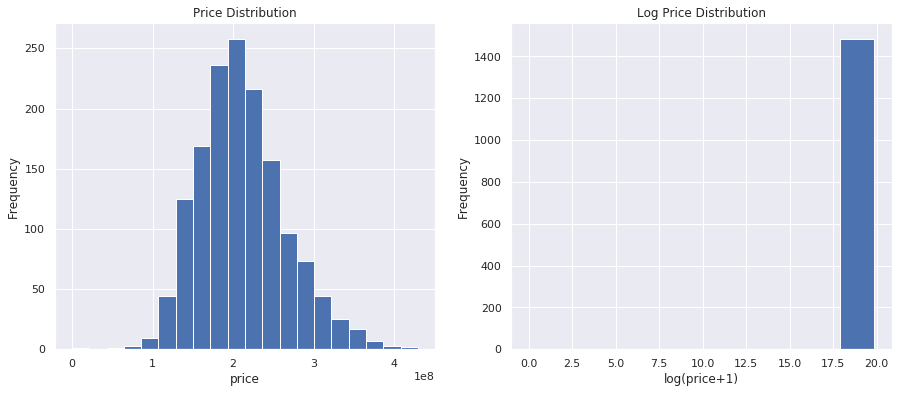

In [0]:
df['Yearly_Sales'] = df['Yearly Sales (No Bex Sales) 年商（Bexセールス含まない）']

df['LOG_Yearly_Sales'] = np.log(df['Yearly_Sales']+1)

# Plot Price Distribution
plt.subplot(1, 2, 1)
(df['Yearly_Sales'] ).plot.hist(bins=20,figsize=(15, 6), edgecolor = 'white')
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)


#_________________________________________________TODO______________________________________________
#Plot Log Price Distribution
plt.subplot(1, 2, 2)
(df['LOG_Yearly_Sales']).plot.hist( figsize=(15,6), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Log Price Distribution', fontsize=12)


plt.show()

#4.Feature selection & assumption check

## 4.1 Select features

In [0]:
features=[
"Market　Desirability Grade",
"Real Estate Rating",
#"DTｾｰﾙｽ比率（％）",
#"Drive Time T.A:9歳以下人口（人）",
"Drive Time T.A:住民人口(人)",
#"Drive Time T.A:推定昼間人口(人)",
"Drive Time T.A: day_night_pop_ratio",
"Drive Time T.A_Age_00_09_pct",
"Drive Time T.A_Age_10_59_pct",
#'2500_Age_10_49 pct',
#"Drive Time T.A:主要QSR+FR+Café店舗数",
"Drive Time T.A:CVS店舗数",

#"700_乗降客数合計",
"450_乗降客数合計",
#"Nearest_Eki_Passenger",
#"2.5km圏:McD DT店舗数",
"2.5km圏:McD IS店舗数",
#'5km圏:McD DT店舗数',
"2.5km- 5km圏:McD DT店舗数",
#'5km圏:McD IS店舗数',
#'最寄DT迄の距離(m)',
#'最寄IS迄の距離(m)'

"専用客席数",
#"専用敷地面積(㎡)",
"専用駐車台数",
#"建物延べ床面積",
]


import statsmodels.api as sm

# Define X Values
X = sm.add_constant(train_df[features])

# Define Y 
Y = train_df['Yearly Sales (No Bex Sales) 年商（Bexセールス含まない）']

# Apply OLS to our X and Y
lm = sm.OLS(Y, X).fit()

# Print Summary of Outputs
lm.summary()

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                         OLS Regression Results                                        
=======================================================================================================
Dep. Variable:     Yearly Sales (No Bex Sales) 年商（Bexセールス含まない）   R-squared:                       0.451
Model:                                                     OLS   Adj. R-squared:                  0.447
Method:                                          Least Squares   F-statistic:                     97.81
Date:                                         Fri, 17 Jan 2020   Prob (F-statistic):          2.85e-176
Time:                                                 05:06:05   Log-Likelihood:                -27288.
No. Observations:                                         1441   AIC:                         5.460e+04
Df Residuals:                                             1428   BIC:                         5.467e+04
Df Model:                                                   12                                         
Covariance Type:                                     nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                3.379e+06   1.71e+07      0.198      0.843   -3.01e+07    3.68e+07
Market　Desirability Grade            9.999e+06   1.31e+06      7.615      0.000    7.42e+06    1.26e+07
Real Estate Rating                   7.652e+06   1.56e+06      4.890      0.000    4.58e+06    1.07e+07
Drive Time T.A:住民人口(人)                522.4204     80.810      6.465      0.000     363.902     680.939
Drive Time T.A: day_night_pop_ratio -1.084e+06   9.22e+05     -1.175      0.240   -2.89e+06    7.25e+05
Drive Time T.A_Age_00_09_pct           5.8e+08   8.28e+07      7.000      0.000    4.17e+08    7.42e+08
Drive Time T.A_Age_10_59_pct         6.889e+07    3.4e+07      2.027      0.043    2.23e+06    1.36e+08
Drive Time T.A:CVS店舗数                3.236e+05   1.36e+05      2.374      0.018    5.62e+04    5.91e+05
450_乗降客数合計                            155.2696     95.862      1.620      0.106     -32.776     343.315
2.5km圏:McD IS店舗数                    -2.734e+06   9.49e+05     -2.880      0.004    -4.6e+06   -8.72e+05
2.5km- 5km圏:McD DT店舗数               -2.132e+06   5.73e+05     -3.720      0.000   -3.26e+06   -1.01e+06
専用客席数                                5.916e+05   4.25e+04     13.915      0.000    5.08e+05    6.75e+05
専用駐車台数                               1.651e+05   7.37e+04      2.240      0.025    2.05e+04     3.1e+05
==============================================================================
Omnibus:                       22.007   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.373
Skew:                           0.138   Prob(JB):                     5.66e-08
Kurtosis:                       3.693   Cond. No.                     3.85e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.85e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##4.3 Detecting Multicollinearity - VIF

**Note:** Multicollinearity isn't so much of a problem if you're main focus is prediction. 

**Why is this a problem:** 
- When two variables are correlated with each other, then they "move together". 
- This is hard for your linear regression model to interpret the exact change of your DV's. 
- It doesn't know which IV is **responsible** for the change in the DV. 
- βi coefficients will be less precise.
- It's harder to accurately interpret the coefficients 

### Reference
- VIF = 1 (Not correlated)
- 1 < VIF < 5 (Moderately correlated)
- VIF >=5 (Highly correlated)

In [0]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = train_df[features].assign(const=1)
pd.Series([variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])],index=X_vif.columns)

Market　Desirability Grade                1.500062
Real Estate Rating                       1.097554
Drive Time T.A:住民人口(人)                   3.353569
Drive Time T.A: day_night_pop_ratio      1.079793
Drive Time T.A_Age_00_09_pct             1.544009
Drive Time T.A_Age_10_59_pct             1.719318
Drive Time T.A:CVS店舗数                    3.429161
450_乗降客数合計                               1.048345
2.5km圏:McD IS店舗数                         1.653424
2.5km- 5km圏:McD DT店舗数                    1.406629
専用客席数                                    1.558916
専用駐車台数                                   1.145840
const                                  252.566025
dtype: float64

## 4.4 Detecting Heteroskedestacity - Residual Plot

Text(0, 0.5, 'Residuals')

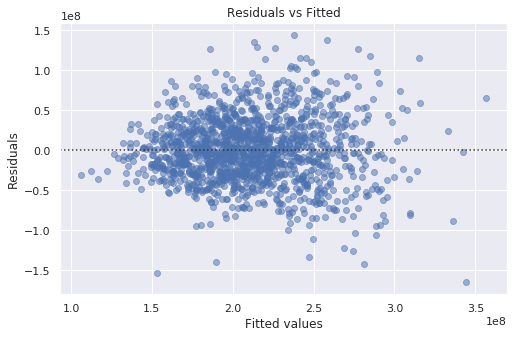

In [0]:
# Non-Logged MEDV
#Y = df.MEDV

# Log Transformed MEDV
Y =   train_df['Yearly Sales (No Bex Sales) 年商（Bexセールス含まない）']

# Apply OLS to our X and Y
lm = sm.OLS(Y, X).fit()

# fitted values (need a constant term for intercept)
model_fitted_y = lm.fittedvalues

# model residuals
model_residuals = lm.resid

# normalized residuals
model_norm_residuals = lm.get_influence().resid_studentized_internal

# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

# absolute residuals
model_abs_resid = np.abs(model_residuals)

# leverage, from statsmodels internals
model_leverage = lm.get_influence().hat_matrix_diag

# cook's distance, from statsmodels internals
model_cooks = lm.get_influence().cooks_distance[0]

# Create residual plot of MEDV vs Residuals
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(5)
plot_lm_1.set_figwidth(8)

model_fitted_y = lm.fittedvalues

plot_lm_1.axes[0] = sns.residplot(model_fitted_y, 'Yearly Sales (No Bex Sales) 年商（Bexセールス含まない）', data=train_df, 
                          scatter_kws={'alpha': 0.5})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')

## 4.5.Detecting Linearity, Normal Distribution of Residuals, & Zero Mean


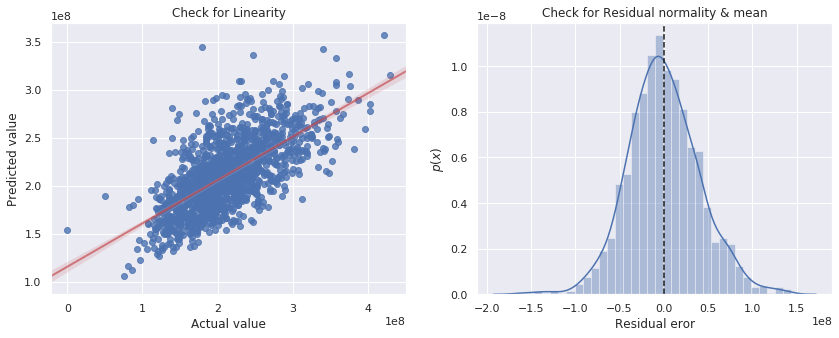

In [0]:
import seaborn as sns; sns.set()

# Check for Linearity
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
#sns.scatterplot(y_test,y_pred_ols,ax=ax,color=['r','g'])
# use the function regplot to make a scatterplot
sns.regplot(x=train_df['Yearly Sales (No Bex Sales) 年商（Bexセールス含まない）'], y=model_fitted_y, line_kws={"color":"r","alpha":0.7,"lw":2})
plt.title('Check for Linearity')
plt.xlabel('Actual value')
plt.ylabel('Predicted value')

# Check for Residual normality & mean
ax = f.add_subplot(122)
sns.distplot((train_df['Yearly Sales (No Bex Sales) 年商（Bexセールス含まない）'] - model_fitted_y),ax=ax,color='b')
plt.axvline((train_df['Yearly Sales (No Bex Sales) 年商（Bexセールス含まない）'] - model_fitted_y).mean(),color='k',linestyle='--')
plt.title('Check for Residual normality & mean')
plt.xlabel('Residual eror')
plt.ylabel('$p(x)$');

## 4.6 Detecting Normal Distribution of Residuals - QQ Plot

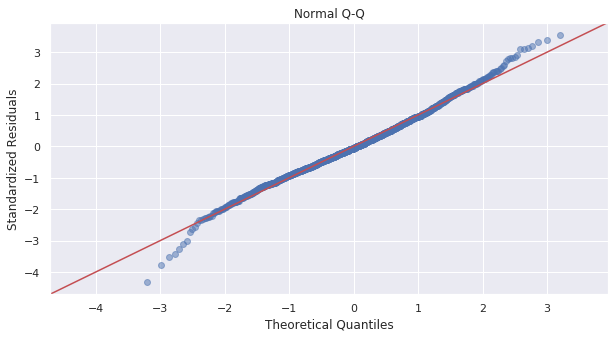

In [0]:
from statsmodels.graphics.gofplots import ProbPlot

QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)

plot_lm_2.set_figheight(5)
plot_lm_2.set_figwidth(10)

plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');

#5.Regression Models

In [0]:
from sklearn import linear_model, model_selection, metrics

# Some more helper functions.
# You don't have to care about them if you don't understand.

def cross_validation(model, x_train, y_train, n_folds=5):
    """Cross validation with shuffle."""
    kfold = (
        model_selection.KFold(n_folds, shuffle=True, random_state=20190216)
            .get_n_splits(x_train)
    )
    rmse = np.sqrt(-model_selection.cross_val_score(
        model,
        x_train,
        y_train,
        scoring="neg_mean_squared_error",
        cv=kfold
    ))
    return rmse


def rmse(y_test, y_pred):
    """Root mean square error."""
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))


def test(model, x_test, y_test):
    """Make predictions and compare with test data."""
    y_pred = model.predict(x_test)
    return rmse(y_test, y_pred), metrics.r2_score(y_test, y_pred)

In [0]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
%matplotlib inline

X = train_df.loc[:, features].values
X = StandardScaler().fit_transform(X)
y = train_df.loc[:,['Yearly Sales (No Bex Sales) 年商（Bexセールス含まない）']].values
y = StandardScaler().fit_transform(y)


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor = LinearRegression()  
regressor.fit(X_train, y_train)
#coeff_df = pd.DataFrame(regressor.coef_, columns=['Coefficient'])  

coeff_df = pd.DataFrame(data=regressor.coef_,columns=features)
#coeff_df['Feature']=X.columns
#coeff_df['coeff']=np.reshape(list(regressor.coef_),(14,1))
coeff_df.T


,0
Market Desirability Grade,0.169465
Real Estate Rating,0.087345
Drive Time T.A:住民人口(人),0.246964
Drive Time T.A: day_night_pop_ratio,-0.017153
Drive Time T.A_Age_00_09_pct,0.160682
Drive Time T.A_Age_10_59_pct,0.059595
Drive Time T.A:CVS店舗数,0.091547
450_乗降客数合計,0.069561
2.5km圏:McD IS店舗数,-0.110964
2.5km- 5km圏:McD DT店舗数,-0.073499


In [0]:
y_pred = regressor.predict(X_test)
linear_regression = linear_model.LinearRegression()
linear_regression.fit(X_train, y_train)
rmse_score, r2_score = test(regressor, X_test, y_test)
print(f'Linear Regression score: RMSE={rmse_score:.4f}, R2={r2_score:.4f}')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Linear Regression score: RMSE=0.7629, R2=0.4754
Mean Absolute Error: 0.5753183575021054
Mean Squared Error: 0.5819951058703208
Root Mean Squared Error: 0.7628860372757655


#6.Model Evaluation（Match RANK TOP10 Sales AVG)

In [0]:
### Perform similarity calculation
EVA_10_count = 0
total_test_rows = len(test_df.index)
Sum_TopRank_y_diff = 0
EVA_df=pd.DataFrame(columns=['Sitecode','EVA%'])

## 2. Calculate Top10 類似店舗 for each test stores
for index, row in test_df.iterrows():
  similarity_ranking = pd.DataFrame(index=train_df.index)
  ## calculate the difference between each features, considering std and coeff.
  for f in features:
    similarity_ranking[f]=(abs(train_df[f]-row[f]))/ train_df[f].std()
  sum_feature_dist = similarity_ranking.dot(coeff_df.T.abs())

  ## Sorting based on the similarity calculation, retrieve TOP2 - TOP9 similary stores
  sum_feature_dist = sum_feature_dist.sort_values(by=0, ascending=True, na_position='last')
  print(sum_feature_dist[2:9])
  similiar_stores = list(sum_feature_dist[2:9].index.values)

## Evaluation Similary store sales results; pct of EVA +10%
  TopRank_y_diff = (df[df.index.isin(similiar_stores)]['Yearly Sales (No Bex Sales) 年商（Bexセールス含まない）'].mean() - df.loc[index,'Yearly Sales (No Bex Sales) 年商（Bexセールス含まない）'] )
  Sum_TopRank_y_diff = Sum_TopRank_y_diff+TopRank_y_diff*TopRank_y_diff
  EVA =  (TopRank_y_diff / df.loc[index,'Yearly Sales (No Bex Sales) 年商（Bexセールス含まない）'] )
  print ("Sitecode:", index," / EVA:",EVA)
  EVA_df=EVA_df.append({'Sitecode' : index , 'EVA%' : EVA} , ignore_index=True)
  if (abs(EVA) < 0.1): EVA_10_count = EVA_10_count + 1

#print(Sum_TopRank_y_diff)
TopRank_RMSE = np.sqrt(Sum_TopRank_y_diff / total_test_rows)
EVA_10_pct = EVA_10_count / total_test_rows

print("TopRank_RMSE: ", TopRank_RMSE)
print("EVA +-10%: ", EVA_10_pct)
print(EVA_10_count)

               0
サイトコード          
9570    0.483269
11080   0.521938
10012   0.529254
11733   0.533565
27730   0.551369
47008   0.563247
33544   0.563590
Sitecode: 22639  / EVA: 0.07729209547744774
               0
サイトコード          
33544   0.532612
27730   0.537680
34557   0.552870
40642   0.554145
8629    0.565094
18004   0.575311
37009   0.593063
Sitecode: 38546  / EVA: 0.018851999119478272
               0
サイトコード          
15510   0.234698
46521   0.248479
1541    0.256887
9519    0.277045
22026   0.285290
25545   0.286838
35528   0.287128
Sitecode: 38545  / EVA: -0.15152583988582988
               0
サイトコード          
1627    0.335512
26576   0.348884
35007   0.353763
8027    0.368193
37522   0.392486
28643   0.397607
25551   0.397907
Sitecode: 25559  / EVA: -0.02690738949028267
               0
サイトコード          
45516   0.172317
43535   0.173088
43534   0.205336
17530   0.208514
28643   0.215010
8619    0.254767
43539   0.256067
Sitecode: 35534  / EVA: -0.061853928278753315
          

In [0]:
print(f'Linear Regression score: RMSE={rmse_score:.4f}, R2={r2_score:.4f}')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("TopRank_RMSE: ", TopRank_RMSE)
print("EVA +-10%: ", EVA_10_pct)

Linear Regression score: RMSE=0.7629, R2=0.4754
Mean Absolute Error: 0.5753183575021054
Mean Squared Error: 0.5819951058703208
Root Mean Squared Error: 0.7628860372757655
TopRank_RMSE:  38071750.80471811
EVA +-10%:  0.5652173913043478


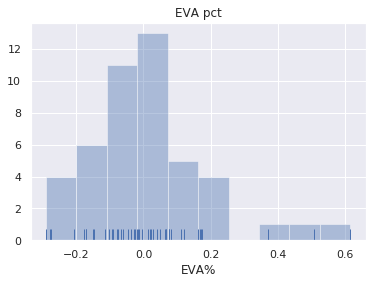

In [0]:
# Check for Residual normality & mean
#sns.distplot(EVA_df['EVA%'],ax=ax,color='b')

sns.distplot(EVA_df['EVA%'], kde=False, rug=True);


plt.title('EVA pct')
plt.show()


In [0]:
df_path='/content/gdrive/My Drive/Model_workbooks/CompModel/output/DT_calculation_data.xlsx'

df[features].to_excel(df_path)

#6.0 Prediction Intellengience: Test data preparation

In [0]:
basic_features=[
"Market　Desirability Grade",
"Real Estate Rating",

#"DTｾｰﾙｽ比率（％）",
#"Drive Time T.A:9歳以下人口（人）",
"Drive Time T.A:住民人口(人)",
#"Drive Time T.A:推定昼間人口(人)",
"Drive Time T.A: day_night_pop_ratio",
"Drive Time T.A_Age_00_09_pct",
"Drive Time T.A_Age_10_59_pct",
#'2500_Age_10_49 pct',
"Drive Time T.A:主要QSR+FR+Café店舗数",
"Drive Time T.A:CVS店舗数",

#"700_乗降客数合計",
"450_乗降客数合計",
#"Nearest_Eki_Passenger",
"2.5km圏:McD DT店舗数",
"2.5km圏:McD IS店舗数",
#'5km圏:McD DT店舗数',
#"2.5km- 5km圏:McD DT店舗数",
#'5km圏:McD IS店舗数',
#'最寄DT迄の距離(m)',
#'最寄IS迄の距離(m)'

"専用客席数",
#"専用敷地面積(㎡)",
"専用駐車台数",
#"建物延べ床面積",
]
features_001=[
"Market　Desirability Grade",
"Real Estate Rating",

#"DTｾｰﾙｽ比率（％）",
#"Drive Time T.A:9歳以下人口（人）",
"Drive Time T.A:住民人口(人)",
#"Drive Time T.A:推定昼間人口(人)",
"Drive Time T.A: day_night_pop_ratio",
"Drive Time T.A_Age_00_09_pct",
"Drive Time T.A_Age_10_59_pct",
#'2500_Age_10_49 pct',
"Drive Time T.A:主要QSR+FR+Café店舗数",
"Drive Time T.A:CVS店舗数",

#"700_乗降客数合計",
"450_乗降客数合計",
#"Nearest_Eki_Passenger",
"2.5km圏:McD DT店舗数",
"2.5km圏:McD IS店舗数",
#'5km圏:McD DT店舗数',
"2.5km- 5km圏:McD DT店舗数",
#'5km圏:McD IS店舗数',
#'最寄DT迄の距離(m)',
#'最寄IS迄の距離(m)'

"専用客席数",
#"専用敷地面積(㎡)",
"専用駐車台数",
#"建物延べ床面積",
]

features_001=[
"Market　Desirability Grade",
"Real Estate Rating",
#"DTｾｰﾙｽ比率（％）",
#"Drive Time T.A:9歳以下人口（人）",
"Drive Time T.A:住民人口(人)",
#"Drive Time T.A:推定昼間人口(人)",
"Drive Time T.A: day_night_pop_ratio",
"Drive Time T.A_Age_00_09_pct",
"Drive Time T.A_Age_10_59_pct",
#'2500_Age_10_49 pct',
"Drive Time T.A:主要QSR+FR+Café店舗数",
"Drive Time T.A:CVS店舗数",
#"700_乗降客数合計",
"450_乗降客数合計",
#"Nearest_Eki_Passenger",
"2.5km圏:McD DT店舗数",
"2.5km圏:McD IS店舗数",
'5km圏:McD DT店舗数',
#"2.5km- 5km圏:McD DT店舗数",
'5km圏:McD IS店舗数',
#'最寄DT迄の距離(m)',
#'最寄IS迄の距離(m)'
"専用客席数",
#"専用敷地面積(㎡)",
"専用駐車台数",
#"建物延べ床面積",
]

features_002=[
"Market　Desirability Grade",
"Real Estate Rating",
#"DTｾｰﾙｽ比率（％）",
#"Drive Time T.A:9歳以下人口（人）",
"Drive Time T.A:住民人口(人)",
#"Drive Time T.A:推定昼間人口(人)",
"Drive Time T.A: day_night_pop_ratio",
"Drive Time T.A_Age_00_09_pct",
"Drive Time T.A_Age_10_59_pct",
#'2500_Age_10_49 pct',
"Drive Time T.A:主要QSR+FR+Café店舗数",
"Drive Time T.A:CVS店舗数",
#"700_乗降客数合計",
"450_乗降客数合計",
#"Nearest_Eki_Passenger",
"2.5km圏:McD DT店舗数",
"2.5km圏:McD IS店舗数",
'5km圏:McD DT店舗数',
"2.5km- 5km圏:McD DT店舗数",
'5km圏:McD IS店舗数',
#'最寄DT迄の距離(m)',
#'最寄IS迄の距離(m)'
"専用客席数",
#"専用敷地面積(㎡)",
"専用駐車台数",
#"建物延べ床面積",
]

features_003=[
"Market　Desirability Grade",
"Real Estate Rating",
#"DTｾｰﾙｽ比率（％）",
#"Drive Time T.A:9歳以下人口（人）",
"Drive Time T.A:住民人口(人)",
#"Drive Time T.A:推定昼間人口(人)",
"Drive Time T.A: day_night_pop_ratio",
"Drive Time T.A_Age_00_09_pct",
"Drive Time T.A_Age_10_59_pct",
#'2500_Age_10_49 pct',
"Drive Time T.A:主要QSR+FR+Café店舗数",
"Drive Time T.A:CVS店舗数",
#"700_乗降客数合計",
"450_乗降客数合計",
#"Nearest_Eki_Passenger",
#"2.5km圏:McD DT店舗数",
"2.5km圏:McD IS店舗数",
#'5km圏:McD DT店舗数',
"2.5km- 5km圏:McD DT店舗数",
'5km圏:McD IS店舗数',
#'最寄DT迄の距離(m)',
#'最寄IS迄の距離(m)'
"専用客席数",
#"専用敷地面積(㎡)",
"専用駐車台数",
#"建物延べ床面積",
]

features_004=[
#"Market　Desirability Grade",
#"Real Estate Rating",
#"DTｾｰﾙｽ比率（％）",
#"Drive Time T.A:9歳以下人口（人）",
"Drive Time T.A:住民人口(人)",
#"Drive Time T.A:推定昼間人口(人)",
"Drive Time T.A: day_night_pop_ratio",
"Drive Time T.A_Age_00_09_pct",
"Drive Time T.A_Age_10_59_pct",
#'2500_Age_10_49 pct',
"Drive Time T.A:主要QSR+FR+Café店舗数",
"Drive Time T.A:CVS店舗数",

#"700_乗降客数合計",
"450_乗降客数合計",
#"Nearest_Eki_Passenger",
"2.5km圏:McD DT店舗数",
"2.5km圏:McD IS店舗数",
#'5km圏:McD DT店舗数',
#"2.5km- 5km圏:McD DT店舗数",
#'5km圏:McD IS店舗数',
#'最寄DT迄の距離(m)',
#'最寄IS迄の距離(m)'

"専用客席数",
#"専用敷地面積(㎡)",
"専用駐車台数",
#"建物延べ床面積",
]

features_005=[
"Market　Desirability Grade",
"Real Estate Rating",
#"DTｾｰﾙｽ比率（％）",
#"Drive Time T.A:9歳以下人口（人）",
"Drive Time T.A:住民人口(人)",
#"Drive Time T.A:推定昼間人口(人)",
"Drive Time T.A: day_night_pop_ratio",
"Drive Time T.A_Age_00_09_pct",
"Drive Time T.A_Age_10_59_pct",
#'2500_Age_10_49 pct',
"Drive Time T.A:主要QSR+FR+Café店舗数",
"Drive Time T.A:CVS店舗数",

#"700_乗降客数合計",
"450_乗降客数合計",
#"Nearest_Eki_Passenger",
"2.5km圏:McD DT店舗数",
"2.5km圏:McD IS店舗数",
#'5km圏:McD DT店舗数',
"2.5km- 5km圏:McD DT店舗数",
#'5km圏:McD IS店舗数',
#'最寄DT迄の距離(m)',
#'最寄IS迄の距離(m)'

"専用客席数",
#"専用敷地面積(㎡)",
"専用駐車台数",
#"建物延べ床面積",
]

features_006=[
"Market　Desirability Grade",
"Real Estate Rating",
#"DTｾｰﾙｽ比率（％）",
#"Drive Time T.A:9歳以下人口（人）",
"Drive Time T.A:住民人口(人)",
#"Drive Time T.A:推定昼間人口(人)",
"Drive Time T.A: day_night_pop_ratio",
"Drive Time T.A_Age_00_09_pct",
"Drive Time T.A_Age_10_59_pct",
#'2500_Age_10_49 pct',
"Drive Time T.A:主要QSR+FR+Café店舗数",
#"Drive Time T.A:CVS店舗数",

#"700_乗降客数合計",
"450_乗降客数合計",
#"Nearest_Eki_Passenger",
"2.5km圏:McD DT店舗数",
"2.5km圏:McD IS店舗数",
#'5km圏:McD DT店舗数',
"2.5km- 5km圏:McD DT店舗数",
#'5km圏:McD IS店舗数',
#'最寄DT迄の距離(m)',
#'最寄IS迄の距離(m)'

"専用客席数",
#"専用敷地面積(㎡)",
"専用駐車台数",
#"建物延べ床面積",
]

features_007=[
"Market　Desirability Grade",
"Real Estate Rating",
#"DTｾｰﾙｽ比率（％）",
#"Drive Time T.A:9歳以下人口（人）",
"Drive Time T.A:住民人口(人)",
#"Drive Time T.A:推定昼間人口(人)",
"Drive Time T.A: day_night_pop_ratio",
"Drive Time T.A_Age_00_09_pct",
"Drive Time T.A_Age_10_59_pct",
#'2500_Age_10_49 pct',
#"Drive Time T.A:主要QSR+FR+Café店舗数",
"Drive Time T.A:CVS店舗数",

#"700_乗降客数合計",
"450_乗降客数合計",
#"Nearest_Eki_Passenger",
"2.5km圏:McD DT店舗数",
"2.5km圏:McD IS店舗数",
#'5km圏:McD DT店舗数',
"2.5km- 5km圏:McD DT店舗数",
#'5km圏:McD IS店舗数',
#'最寄DT迄の距離(m)',
#'最寄IS迄の距離(m)'

"専用客席数",
#"専用敷地面積(㎡)",
"専用駐車台数",
#"建物延べ床面積",
]

features_008=[
"Market　Desirability Grade",
"Real Estate Rating",
#"DTｾｰﾙｽ比率（％）",
#"Drive Time T.A:9歳以下人口（人）",
"Drive Time T.A:住民人口(人)",
#"Drive Time T.A:推定昼間人口(人)",
#"Drive Time T.A: day_night_pop_ratio",
"Drive Time T.A_Age_00_09_pct",
"Drive Time T.A_Age_10_59_pct",
#'2500_Age_10_49 pct',
#"Drive Time T.A:主要QSR+FR+Café店舗数",
"Drive Time T.A:CVS店舗数",

#"700_乗降客数合計",
"450_乗降客数合計",
#"Nearest_Eki_Passenger",
"2.5km圏:McD DT店舗数",
"2.5km圏:McD IS店舗数",
#'5km圏:McD DT店舗数',
"2.5km- 5km圏:McD DT店舗数",
#'5km圏:McD IS店舗数',
#'最寄DT迄の距離(m)',
#'最寄IS迄の距離(m)'

"専用客席数",
#"専用敷地面積(㎡)",
"専用駐車台数",
#"建物延べ床面積",
]
features_009=[
"Market　Desirability Grade",
"Real Estate Rating",
#"DTｾｰﾙｽ比率（％）",
#"Drive Time T.A:9歳以下人口（人）",
"Drive Time T.A:住民人口(人)",
#"Drive Time T.A:推定昼間人口(人)",
"Drive Time T.A: day_night_pop_ratio",
"Drive Time T.A_Age_00_09_pct",
"Drive Time T.A_Age_10_59_pct",
#'2500_Age_10_49 pct',
#"Drive Time T.A:主要QSR+FR+Café店舗数",
"Drive Time T.A:CVS店舗数",

#"700_乗降客数合計",
"450_乗降客数合計",
#"Nearest_Eki_Passenger",
#"2.5km圏:McD DT店舗数",
"2.5km圏:McD IS店舗数",
'5km圏:McD DT店舗数',
"2.5km- 5km圏:McD DT店舗数",
#'5km圏:McD IS店舗数',
#'最寄DT迄の距離(m)',
#'最寄IS迄の距離(m)'

"専用客席数",
#"専用敷地面積(㎡)",
"専用駐車台数",
#"建物延べ床面積",
]
features_010=[
"Market　Desirability Grade",
"Real Estate Rating",
#"DTｾｰﾙｽ比率（％）",
#"Drive Time T.A:9歳以下人口（人）",
"Drive Time T.A:住民人口(人)",
#"Drive Time T.A:推定昼間人口(人)",
"Drive Time T.A: day_night_pop_ratio",
"Drive Time T.A_Age_00_09_pct",
"Drive Time T.A_Age_10_59_pct",
#'2500_Age_10_49 pct',
#"Drive Time T.A:主要QSR+FR+Café店舗数",
"Drive Time T.A:CVS店舗数",

#"700_乗降客数合計",
"450_乗降客数合計",
#"Nearest_Eki_Passenger",
"2.5km圏:McD DT店舗数",
"2.5km圏:McD IS店舗数",
'5km圏:McD DT店舗数',
#"2.5km- 5km圏:McD DT店舗数",
'5km圏:McD IS店舗数',
#'最寄DT迄の距離(m)',
#'最寄IS迄の距離(m)'

"専用客席数",
#"専用敷地面積(㎡)",
"専用駐車台数",
#"建物延べ床面積",
]

features_011=[
"Market　Desirability Grade",
"Real Estate Rating",
#"DTｾｰﾙｽ比率（％）",
#"Drive Time T.A:9歳以下人口（人）",
"Drive Time T.A:住民人口(人)",
#"Drive Time T.A:推定昼間人口(人)",
"Drive Time T.A: day_night_pop_ratio",
"Drive Time T.A_Age_00_09_pct",
"Drive Time T.A_Age_10_59_pct",
#'2500_Age_10_49 pct',
#"Drive Time T.A:主要QSR+FR+Café店舗数",
"Drive Time T.A:CVS店舗数",

#"700_乗降客数合計",
"450_乗降客数合計",
#"Nearest_Eki_Passenger",
#"2.5km圏:McD DT店舗数",
"2.5km圏:McD IS店舗数",
#'5km圏:McD DT店舗数',
"2.5km- 5km圏:McD DT店舗数",
#'5km圏:McD IS店舗数',
#'最寄DT迄の距離(m)',
#'最寄IS迄の距離(m)'

"専用客席数",
#"専用敷地面積(㎡)",
"専用駐車台数",
#"建物延べ床面積",
]

features_012=[
"Market　Desirability Grade",
"Real Estate Rating",
#"DTｾｰﾙｽ比率（％）",
#"Drive Time T.A:9歳以下人口（人）",
"Drive Time T.A:住民人口(人)",
#"Drive Time T.A:推定昼間人口(人)",
"Drive Time T.A: day_night_pop_ratio",
"Drive Time T.A_Age_00_09_pct",
"Drive Time T.A_Age_10_59_pct",
#'2500_Age_10_49 pct',
#"Drive Time T.A:主要QSR+FR+Café店舗数",
"Drive Time T.A:CVS店舗数",

#"700_乗降客数合計",
"450_乗降客数合計",
#"Nearest_Eki_Passenger",
"2.5km圏:McD DT店舗数",
"2.5km圏:McD IS店舗数",
'5km圏:McD DT店舗数',
#"2.5km- 5km圏:McD DT店舗数",
#'5km圏:McD IS店舗数',
#'最寄DT迄の距離(m)',
#'最寄IS迄の距離(m)'

"専用客席数",
#"専用敷地面積(㎡)",
"専用駐車台数",
#"建物延べ床面積",
]
model_version_dict={
    '000':basic_features,
    '001_5km_MCD':features_001,
    '002_2_5km_5km_MCD':features_002,
    '003_2_5km_only_MCD':features_003,
    '004_nbasic_no_rating':features_004,
    '005_2_5km_5km':features_005,
    '006_no_CVS_005T':features_006,
    '007_only_CVS_005T':features_007,
    '008_no_daypop_007T':features_008,
    '009_MCD_007T':features_009,   
     '010_MCD_all_007T':features_010,
     '011_MCD_all_007T':features_011,
     '012_MCD_all_007T':features_012    
    }






# 6.1 Prediction Intellengience.

In [0]:
def predict_summary(df,train_df, test_df, target_Y,selected_features, model_version):
  X = train_df.loc[:, selected_features].values
  X = StandardScaler().fit_transform(X)
  y = train_df.loc[:,[target_Y]].values
  y = StandardScaler().fit_transform(y)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
  regressor = LinearRegression()  
  regressor.fit(X_train, y_train)
  coeff_df = pd.DataFrame(data=regressor.coef_,columns=selected_features)
  
  y_pred = regressor.predict(X_test)
  linear_regression = linear_model.LinearRegression()
  linear_regression.fit(X_train, y_train)
  rmse_score, r2_score = test(regressor, X_test, y_test)

  ### Perform similarity calculation
  EVA_10_count = 0
  total_test_rows = len(test_df.index)

  Sum_TopRank_y_diff = 0
  EVA_df=pd.DataFrame(columns=['Sitecode','EVA%'])
  ## 2. Calculate Top10 類似店舗 for each test stores
  for index, row in test_df.iterrows():
    similarity_ranking = pd.DataFrame(index=train_df.index)
    ## calculate the difference between each features, considering std and coeff.
    for f in selected_features:
      similarity_ranking[f]=(abs(train_df[f]-row[f]))/ train_df[f].std()
    sum_feature_dist = similarity_ranking.dot(coeff_df.T.abs())

    ## Sorting based on the similarity calculation, retrieve TOP2 - TOP9 similary stores
    sum_feature_dist = sum_feature_dist.sort_values(by=0, ascending=True, na_position='last')
    similiar_stores = list(sum_feature_dist[2:9].index.values)

  ## Evaluation Similary store sales results; pct of EVA +10%
    TopRank_y_diff = (df[df.index.isin(similiar_stores)][target_Y].mean() - df.loc[index,target_Y] )
    Sum_TopRank_y_diff = Sum_TopRank_y_diff+TopRank_y_diff*TopRank_y_diff
    EVA =  (TopRank_y_diff / df.loc[index,target_Y] )
   # print ("Sitecode:", index," / EVA:",EVA)
    EVA_df=EVA_df.append({'Sitecode' : index , 'EVA%' : EVA} , ignore_index=True)
    if (abs(EVA) < 0.1): EVA_10_count = EVA_10_count + 1

#print(Sum_TopRank_y_diff)
  TopRank_RMSE = np.sqrt(Sum_TopRank_y_diff / total_test_rows)
  EVA_10_pct = EVA_10_count / total_test_rows

  #print("TopRank_RMSE: ", TopRank_RMSE)
  #print("EVA +-10%: ", EVA_10_pct)

  #Save histogram figure
 
  f = plt.figure(figsize=(14,5))
  ax = f.add_subplot(121)
  sns.distplot(EVA_df['EVA%'], ax=ax,kde=False, rug=True);
  plt.title(model_version)
  fig_path='/content/gdrive/My Drive/Model_workbooks/CompModel/output/figure/'+model_version+'.png'
  plt.savefig(fig_path)

  result_d={'model_version':model_version,'RMSE':rmse_score,'R2':r2_score,'EVA +-10%_pct':EVA_10_pct,'EVA +-10%_std':EVA_df['EVA%'].std()}
  #model_result_df = pd.DataFrame(data=result_d)
  return result_d

,model_version,RMSE,R2,EVA +-10%_pct,EVA +-10%_std
0,000,0.765406,0.471938,0.543478,0.181761
1,001_5km_MCD,0.759522,0.480025,0.456522,0.187788
2,002_2_5km_5km_MCD,0.759522,0.480025,0.391304,0.189067
3,003_2_5km_only_MCD,0.762758,0.475584,0.413043,0.184426
4,004_nbasic_no_rating,0.804526,0.416579,0.478261,0.182402
5,005_2_5km_5km,0.761466,0.477360,0.521739,0.190992
6,006_no_CVS_005T,0.762378,0.476107,0.456522,0.169894
7,007_only_CVS_005T,0.760511,0.478670,0.500000,0.178652
8,008_no_daypop_007T,0.761379,0.477478,0.500000,0.184197
9,009_MCD_007T,0.760511,0.478670,0.543478,0.178635


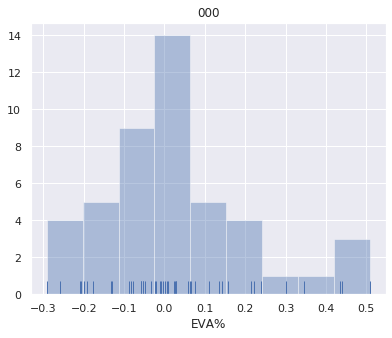

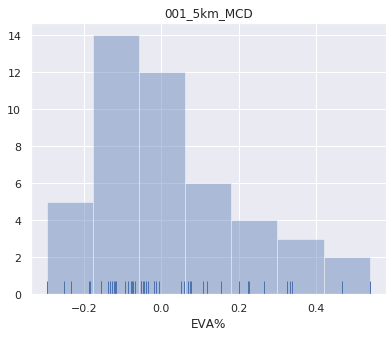

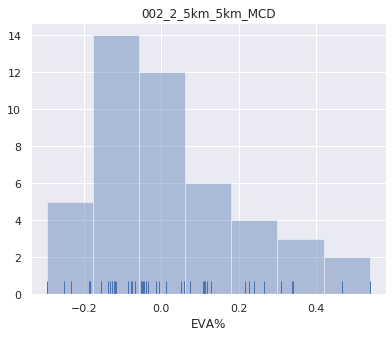

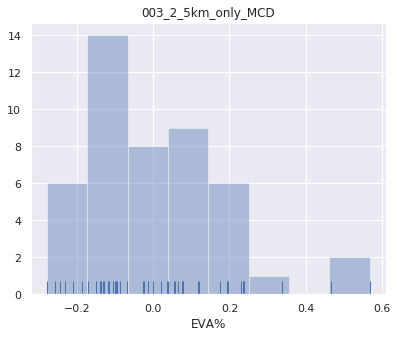

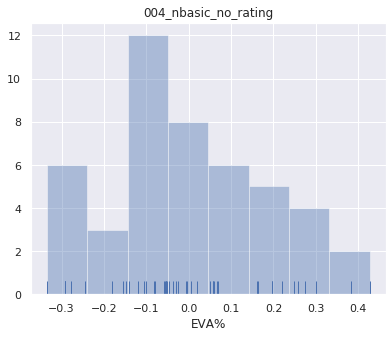

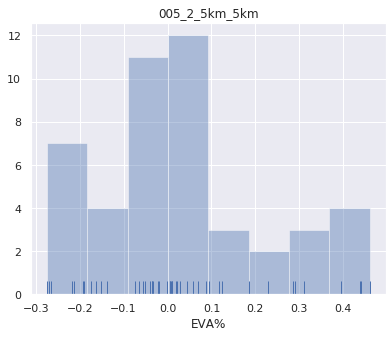

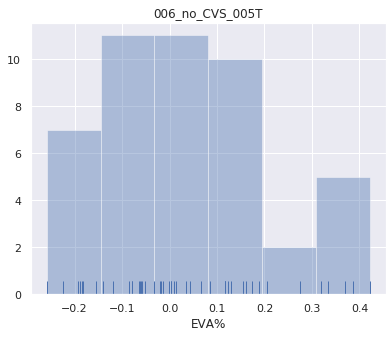

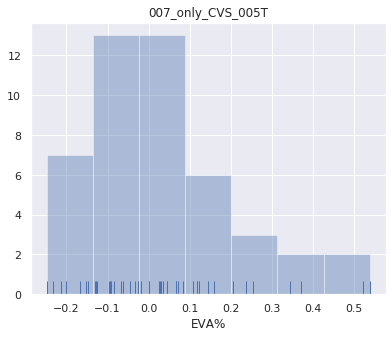

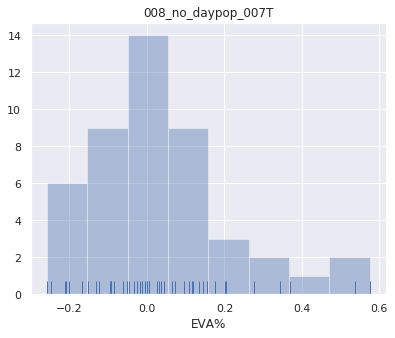

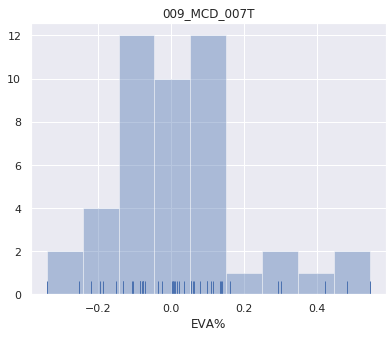

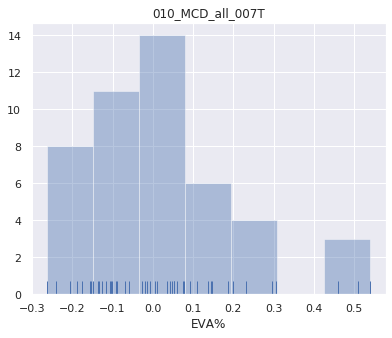

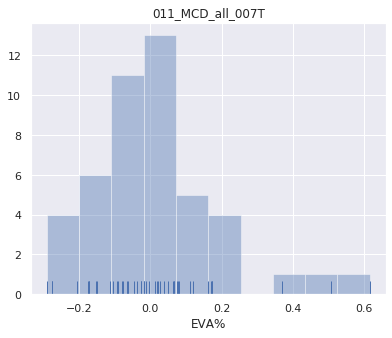

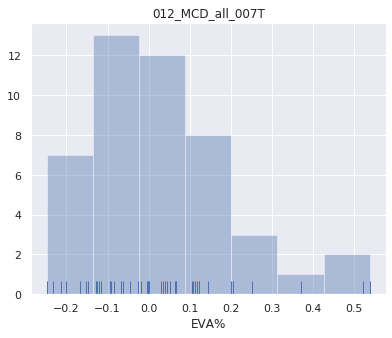

In [0]:
model_result=pd.DataFrame(columns=['model_version','RMSE','R2','EVA +-10%_pct','EVA +-10%_std'])

for key in model_version_dict:
  #print('start to process:',key)
  new_row = predict_summary(df,train_df,test_df,'Yearly Sales (No Bex Sales) 年商（Bexセールス含まない）',model_version_dict[key],key)
  #model_result=pd.concat(model_result,new)
  model_result=model_result.append(new_row, ignore_index=True)
  
 #print(key)
 #print(model_version_dict[key])
model_result

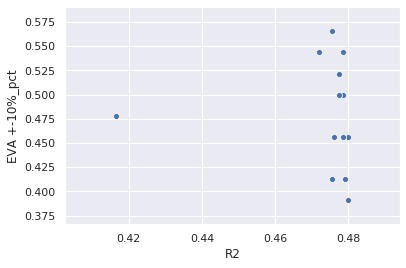

In [0]:
ax = sns.scatterplot(x="R2", y="EVA +-10%_pct", data=model_result)

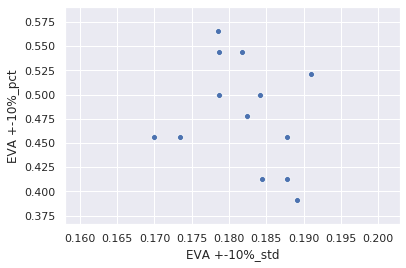

In [0]:
ax = sns.scatterplot(x="EVA +-10%_std", y="EVA +-10%_pct", data=model_result)

In [0]:
df_path='/content/gdrive/My Drive/Model_workbooks/CompModel/output/DT_calculation_data.xlsx'
df[features].to_excel(df_path)